## Modeling


**Goal**: Provide a data-driven understanding of how vaccinations are impacting the course of the pandemic, especially in the context of mortality rates.

**Key research questions**:

* **Q1**: How far back in the past should we look to predict future COVID-19 mortality rates? Are there specific times of the week or month that are more critical for forecasting? --> **Methods used to answer the Question: Random Forest Regressor + ForecasterAutoreg Techniques**.

* **Q2**: Can we accurately predict upcoming COVID-19 mortality rates to optimize healthcare resource planning? --> **Methods: Random Forest Regressor**.

* **Q3**: What are the key factors driving COVID-19 mortality rates, enabling policymakers to target these areas effectively? What's the vaccine effectiveness? --> **Methods: Random Forest Regressor + Feature Importance Techniques**.  

* **Q4**: How can we detect model drift over time to determine if the same predictive model remains valid for extended periods? --> **Methods: Comparative analysis of models predictive power for 1- vs 3-month forecast**.

* **Q5 (Optional)**: Is there a noticeable lag between vaccine administration and its effectiveness, to assist policymakers in timing new vaccination campaigns? --> **Methods: tbc**.

#### **Packages**

In [149]:
!pip install xgboost mlflow skforecast lightgbm -q

In [150]:
pip install skforecast

In [159]:
import  numpy as np
import  pandas as pd
import  matplotlib.pyplot as plt

from    datetime import datetime
import  os
import  pickle
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)

# general
import numpy as np
import pandas as pd

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from    skforecast.ForecasterAutoreg import ForecasterAutoreg
from    sklearn.ensemble import RandomForestRegressor
from    sklearn.metrics import mean_squared_error, r2_score
from    sklearn.preprocessing import OneHotEncoder, StandardScaler
from    xgboost import XGBRegressor
from    lightgbm import LGBMRegressor
from    skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_absolute_error

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
import plotly.express as px

# visualization
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline

In [152]:
from    google.colab import drive
drive.mount('/content/gdrive')

PROJECT_PATH  = '/content/gdrive/MyDrive/OperAI/final-project'
VIZ_PATH      = os.path.join(PROJECT_PATH, 'viz')
DATA_PATH     = os.path.join(PROJECT_PATH, 'data')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **Data desc**

**df_county dataset**
- ID
  - `fips`: County identifier (str of len 5)
  - `recip_county`: County Name
  - `recip_state`: County State
  - `combined_key`: County Name, State, Country

- Data Quality
  - `completeness_pct`: Provides an indication of how much vaccination data was available. A lower percentage indicates we made more of a leap in imputing dose administration.

- Time
  - `date`: Date
  - `mmwr_week`: Week in the year (1-52). This could be useful given potential disease spread seasonality.
  - `phase_1_train`: (bool) Prior to April 1, 2022
  - `phase_1_test`: (bool) April 1, 2022 through June 30, 2022
  - `phase_2_train`: (bool) Prior to July 1, 2022
  - `phase_2_test`: (bool) July 1, 2022 through September 2022

- Categorical
  - `svi_ctgy`: Social Vulnerability Index, which measures potential negative effects on communities caused by external stresses on human health. See [ASTDR Webpage](https://www.atsdr.cdc.gov/placeandhealth/svi/index.html).
  - `metro_status`: Metro or Non-Metro. Provides some indication of population density.

- Population
  - `population`: County population. Can use for any additional percentages we need.

- Dose Administration
  - `dose_admin_pct_<age>`: Total administered doses / Total available doses / `completeness_pct`. I.e., total administered doses adjusted for data completeness.

- Dose Availability: These variables should allow us to "date" the COVID "era" we are in, which may help the model explain some of the large jumps/drops in dose administration percentage.
  - `dose_1_avail_<age>`: For age groups 5+, 12+, 18+, 65+
  - `dose_2_avail_<age>`: For age groups 5+, 12+, 18+, 65+
  - `booster_1_avail_<age>`: For age groups 5+, 12+, 18+, 65+
  - `booster_2_avail_<age>`: For age group 65+ only
  - `booster_bivalent_avail_<age>`: For age groups 5+, 12+, 18+, 65+
  
- Deaths
  - `cum_deaths`: Cumulative deaths (secondary $y$)
  - `daily_deaths`: Daily deaths (primary $y$)
  - `cum_death_pct`: Cumulative deaths (secondary $y$)
  - `daily_death_pct`: Daily deaths (primary $y$)

**df_state dataset**
- ID
  - `recip_state`: County State
  - `combined_key`: County Name, State, Country
- Time
  - `date`: Date
  - `month`: categorical for seasonal trends
  - `dayofweek`: categorical for week data trends
  - `phase_1_train`: (bool) Prior to April 1, 2022
  - `phase_1_test`: (bool) April 1, 2022 through June 30, 2022
  - `phase_2_train`: (bool) Prior to July 1, 2022
  - `phase_2_test`: (bool) July 1, 2022 through September 2022

- Population
  - `population`: County population. Can use for any additional percentages we need.

- Social Vulnerability Index (SVI) Population Exposure
  - `pop_in_<SVI category>`: Total number of people exposed to counties with given SVI index.

- Metro Area Population
  - `pop_in_<Metro category>`: Total number of people in metro versus non-metro areas.

- Dose Administration Percentages
  - `pct_doses_admin_<age>`: Dose Administration Percentage (DAP)
  
  $$\text{doses administered}_{i,t,a} = \sum_{j \in i} \frac{\text{doses administered}_{j,a}}{\text{completeness}_{j,a}}$$

  $$\text{doses available}_{i,t,a} = \sum_{j \in i} \text{doses available}_{t,a} \times \text{population}_{j,t,a}$$

  $$\text{DAP}_{i,t,a} = \frac{\text{doses administered}_{i,t,a}}{\text{doses available}_{i,t,a}}$$


- Deaths (`deaths` (target); `deaths` (lagged))
  - `cum_deaths`: Cumulative deaths (secondary $y$)
  - `daily_deaths`: Daily deaths (primary $y$)
  - `cum_death_pct`: Cumulative deaths (secondary $y$)
  - `daily_death_pct`: Daily deaths (primary $y$)

#### **Data loading**

In [153]:
df_county = pd.read_pickle(os.path.join(DATA_PATH, 'df_timeseries.pkl'))
#df_county.sample(2)

In [154]:
df_state = pd.read_pickle(os.path.join(DATA_PATH, 'df_state_timeseries.pkl'))
df_state.sample(2)

,recip_state,date,phase_1_train,phase_1_test,phase_2_train,phase_2_test,month,dayofweek,population,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,cum_deaths,daily_deaths,cum_death_pct,daily_death_pct
15835,MT,2022-05-18,False,True,True,False,5,2,1068778.0,0.694286,0.167252,0.091054,0.047407,0.349756,0.650244,0.006448,0.005637,0.005825,0.008063,3381.0,0.0,0.003163,0.000000
299,AK,2021-10-08,True,False,True,False,10,4,722343.0,0.008043,0.831958,0.073799,0.086200,0.682731,0.317269,0.000000,0.006506,0.006678,0.008445,586.0,1.0,0.000811,0.000001


#### **Preprocessing**

In [155]:
# Just loaded the preprocessed dataset. The preprocessing includes:
# 1. Encoding categorical variables ['month', 'dayofweek']
# 2. Splitting the data into X and y: X (original + one-hot encoded); y_vars = ['recip_state', 'date', 'daily_death_pct'])
# 3. Splitting the data into train and test
# 4. Scaling the data using StandardScaler()

with open(os.path.join(DATA_PATH, 'covid_preprocessed_data_v3.pkl'), 'rb') as f:
    (X_tr_phase1, y_tr_phase1, X_te_phase1, y_te_phase1,
     X_tr_phase2, y_tr_phase2, X_te_phase2, y_te_phase2) = pickle.load(f)

print('Shapes')
print('-'*60)
print(f'[Phase 1 Train]  x: {X_tr_phase1.shape}\t y: {y_tr_phase1.shape}') #
print(f'[Phase 1 Test]   x: {X_te_phase1.shape}\t y: {y_te_phase1.shape}')
print(f'[Phase 2 Train]  x: {X_tr_phase2.shape}\t y: {y_tr_phase2.shape}')
print(f'[Phase 2 Test]   x: {X_te_phase2.shape}\t y: {y_te_phase2.shape}')
print('-'*60)

X_tr_phase1.head(2)

Shapes
------------------------------------------------------------
[Phase 1 Train]  x: (24648, 31)	 y: (24648, 3)
[Phase 1 Test]   x: (4732, 31)	 y: (4732, 3)
[Phase 2 Train]  x: (29380, 31)	 y: (29380, 3)
[Phase 2 Test]   x: (4784, 31)	 y: (4784, 3)
------------------------------------------------------------


,recip_state,date,population,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,daily_death_pct,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,AK,2020-12-13,-0.783271,-1.02469,2.43905,-0.981097,-0.459093,-0.504613,0.504613,-0.545375,-1.706881,-1.826522,-2.094364,-0.332638,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,2.443479
52,AK,2020-12-14,-0.783271,-1.02469,2.43905,-0.981097,-0.459093,-0.504613,0.504613,-0.545375,-1.706881,-1.826522,-2.094364,-0.332638,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253


In [156]:
# Do additonal pre-processing to account for different prediction horizons

# Phase 1

X_tr_phase1 = X_tr_phase1
y_tr_phase1 = y_tr_phase1

## 1-month prediction: y = April 2022

X_te_phase1_1month = X_te_phase1[(X_te_phase1['date'] >= '2022-04-01') & (X_te_phase1['date'] <= '2022-04-30')]
y_te_phase1_1month = y_te_phase1[X_te_phase1['date'].isin(X_te_phase1_1month['date'])]

## 3-month prediction: y = April-June 2022

X_te_phase1_3month = X_te_phase1[(X_te_phase1['date'] >= '2022-04-01') & (X_te_phase1['date'] <= '2022-06-30')]
y_te_phase1_3month = y_te_phase1[X_te_phase1['date'].isin(X_te_phase1_3month['date'])]

# -----------------------------------------------------------------------------------------------------------------

# Phase 2

X_tr_phase2 = X_tr_phase2
y_tr_phase2 = y_tr_phase2

## 1-month prediction: y = July 2022

X_te_phase2_1month = X_te_phase2[(X_te_phase2['date'] >= '2022-07-01') & (X_te_phase2['date'] <= '2022-07-31')]
y_te_phase2_1month = y_te_phase2[X_te_phase2['date'].isin(X_te_phase2_1month['date'])]

## 3-month prediction: y = July-September 2022

X_te_phase2_3month = X_te_phase2[(X_te_phase2['date'] >= '2022-07-01') & (X_te_phase2['date'] <= '2022-09-30')]
y_te_phase2_3month = y_te_phase2[X_te_phase2['date'].isin(X_te_phase2_3month['date'])]

# -----------------------------------------------------------------------------------------------------------------

print(X_tr_phase1.shape[0]        == y_tr_phase1.shape[0])
print(X_te_phase1_1month.shape[0] == y_te_phase1_1month.shape[0])
print(X_te_phase1_3month.shape[0] == y_te_phase1_3month.shape[0])

print(X_tr_phase2.shape[0]        == y_tr_phase2.shape[0])
print(X_te_phase2_1month.shape[0] == y_te_phase2_1month.shape[0])
print(X_te_phase2_3month.shape[0] == y_te_phase2_3month.shape[0])

True
True
True
True
True
True


#### **Model building and hyperparameter tuning**

**Step 0**: Model-specific preprocessing (optional); **Step 1**: Model definition; **Step 2**: Model training; **Step 3**: Getting predictions; **Step 4**: Performance evaluation; **Step 5**: Hyperparameter tuning; **Step 6**: Interpretability (feature importance).


##### **Method 1: Random Forest Regressor + ForecasterAutoreg Techniques**
**Q1**: How far back in the past should we look to predict future COVID-19 mortality rates? Are there specific times of the week or month that are more critical for forecasting?

###### **Phase 1**

In [193]:
# Local configs
freq          = 'D' # pick: 'D' or 'W' (for some reason 'W' doesn't work as expected, so let's just keep daily)
n_estimators  = 2
max_depth     = 2
random_state  = 123
lags          = 21

In [194]:
# Model definition, training, and getting predictions

def train_and_predict_autoreg_model(X_train, y_train, X_test, lags):

    forecaster = ForecasterAutoreg(regressor=RandomForestRegressor(n_estimators = n_estimators,
                                                                   max_depth    = max_depth,
                                                                   random_state = random_state),
                                   lags=lags)
    forecaster.fit(y=y_train)
    predictions = forecaster.predict(steps=len(X_test))
    feature_importances = forecaster.get_feature_importances()
    return predictions, feature_importances

predictions_1month_phase1_state_autoreg           = {}
predictions_3month_phase1_state_autoreg           = {}
lagged_feature_importance_phase1_state_autoreg    = {}
model_performance_phase1_state_autoreg            = {}

for state in X_tr_phase1['recip_state'].unique():

    # Filter the X, y train data for the state
    X_train_state = X_tr_phase1[X_tr_phase1['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state'])
    y_train_state = y_tr_phase1[y_tr_phase1['recip_state'] == state].set_index('date').asfreq(freq)['daily_deaths']

    # Filter the X test data for the state
    X_test_state_1month = X_te_phase1_1month[X_te_phase1_1month['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state']).fillna(method='ffill')
    X_test_state_3month = X_te_phase1_3month[X_te_phase1_3month['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state']).fillna(method='ffill')

    # Filter the y test data for the state
    y_true_1month = y_te_phase1_1month[y_te_phase1_1month['recip_state'] == state].set_index('date').asfreq(freq).fillna(method='ffill')['daily_deaths']
    y_true_3month = y_te_phase1_3month[y_te_phase1_3month['recip_state'] == state].set_index('date').asfreq(freq).fillna(method='ffill')['daily_deaths']

    if not X_train_state.empty and not y_train_state.empty:

        # Predict for 1-month and 3-month & get feature importances
        predictions_1month_phase1_state_autoreg[state], lagged_feature_importance_phase1_state_autoreg[state] = train_and_predict_autoreg_model(X_train_state, y_train_state, X_test_state_1month, lags)
        predictions_3month_phase1_state_autoreg[state], lagged_feature_importance_phase1_state_autoreg[state] = train_and_predict_autoreg_model(X_train_state, y_train_state, X_test_state_3month, lags)

        # Evaluate the perfomance for 1-month and 3-month
        r2_1month = r2_score(y_true_1month, predictions_1month_phase1_state_autoreg[state])
        mae_1month = mean_absolute_error(y_true_1month, predictions_1month_phase1_state_autoreg[state])

        r2_3month = r2_score(y_true_3month, predictions_3month_phase1_state_autoreg[state])
        mae_3month = mean_absolute_error(y_true_3month, predictions_3month_phase1_state_autoreg[state])

        model_performance_phase1_state_autoreg[state] = {'1month_R2': r2_1month, '1month_MAE': mae_1month, '3month_R2': r2_3month, '3month_MAE': mae_3month}

    else:
        print(f"No data available for state: {state}")

# Sum predictions to get national result
predictions_1month_phase1_national_autoreg = sum(predictions_1month_phase1_state_autoreg.values())
predictions_3month_phase1_national_autoreg = sum(predictions_3month_phase1_state_autoreg.values())

In [195]:
# Model performance evaluation per state

df_model_performance_phase1_state_autoreg = pd.DataFrame.from_dict(model_performance_phase1_state_autoreg, orient='index')
df_model_performance_phase1_state_autoreg.reset_index(inplace=True)
df_model_performance_phase1_state_autoreg.rename(columns={'index': 'State'}, inplace=True)
df_model_performance_phase1_state_autoreg.head()

,State,1month_R2,1month_MAE,3month_R2,3month_MAE
0,AK,0.234906,1.611262,-0.592597,3.209635
1,AL,-1.316880,14.392964,-4.826440,17.140464
2,AR,-0.605366,4.043497,-0.659029,4.543873
3,AZ,0.710275,27.205997,-0.036243,31.881425
4,CA,-0.083309,47.508069,-0.508923,54.102620


In [196]:
# Model performance evaluation nationally

mean_1month_R2 = df_model_performance_phase1_state_autoreg['1month_R2'].mean()
mean_1month_MAE = df_model_performance_phase1_state_autoreg['1month_MAE'].mean()
mean_3month_R2 = df_model_performance_phase1_state_autoreg['3month_R2'].mean()
mean_3month_MAE = df_model_performance_phase1_state_autoreg['3month_MAE'].mean()

mean_1month_R2, mean_1month_MAE, mean_3month_R2, mean_3month_MAE

(-6.568748064878946,
 22.178598718343014,
 -3.439536474444915,
 20.629383794872236)

In [197]:
# Interpretability

combined_importances = pd.concat([pd.DataFrame(importances).assign(state=state) for state,
                                  importances in lagged_feature_importance_phase1_state_autoreg.items()])
fig = px.box(combined_importances, x='feature', y='importance',
             title='Total Lagged Feature Importances Across All States (Phase 1)')
fig.update_layout(xaxis_title='A lagged value of the daily death', yaxis_title='Importance')
fig.show()

How to read the chart:
* Each feature in our model represents a lagged value of the daily death percentage. For example, lag_1 is the death percentage from the previous day, lag_2 from two days ago, and so on up to lag_21.
* The importance of a lagged feature indicates how much influence past values of the death percentage have on predicting future values.
* By analyzing this chart, policymakers and health officials can gain insights into which historical data points (i.e., days in the past relative to the current prediction) are most influential in predicting daily death percentages.
* If certain lags consistently show higher importance, strategies and interventions could be timed accordingly to anticipate and react to trends in mortality rates.

**Takeaway: As we can see, weekly lags (like lag_7, lag_14, lag_21) do indicate the influence of weekends on reporting deaths. Therefore, for the best performance we might need to resample our data at 7-day internal (JTBD for Phase 2).**


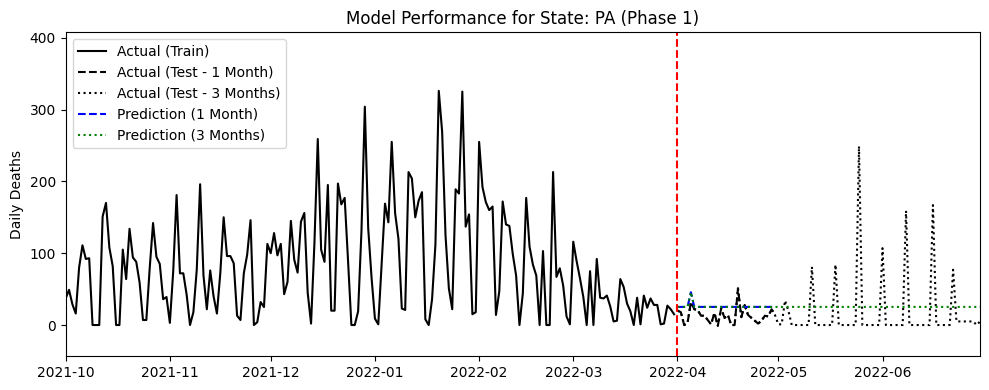

In [198]:
# Viz of predictions (state)

state = 'PA' # Pick the state

# Actual data
y_train_actual = y_tr_phase1[y_tr_phase1['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']
y_test_actual_1month = y_te_phase1_1month[y_te_phase1_1month['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']
y_test_actual_3month = y_te_phase1_3month[y_te_phase1_3month['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']

# Predicted data
y_pred_1month = pd.Series(predictions_1month_phase1_state_autoreg[state], index=y_test_actual_1month.index)
y_pred_3month = pd.Series(predictions_3month_phase1_state_autoreg[state], index=y_test_actual_3month.index)

fig, ax = plt.subplots(figsize=(10, 4))

# Plot actual data
ax.plot(y_train_actual, color='black', label='Actual (Train)')
ax.plot(y_test_actual_1month, color='black', linestyle='--', label='Actual (Test - 1 Month)')
ax.plot(y_test_actual_3month, color='black', linestyle=':', label='Actual (Test - 3 Months)')

# Plot predictions
ax.plot(y_pred_1month, color='blue', linestyle='--', label='Prediction (1 Month)')
ax.plot(y_pred_3month, color='green', linestyle=':', label='Prediction (3 Months)')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 6, 30))) # Set the time range for x-axis (modify as per your data range)

ax.set_ylabel('Daily Deaths')
ax.set_title(f'Model Performance for State: {state} (Phase 1)')

plt.legend()
plt.tight_layout()
plt.show()

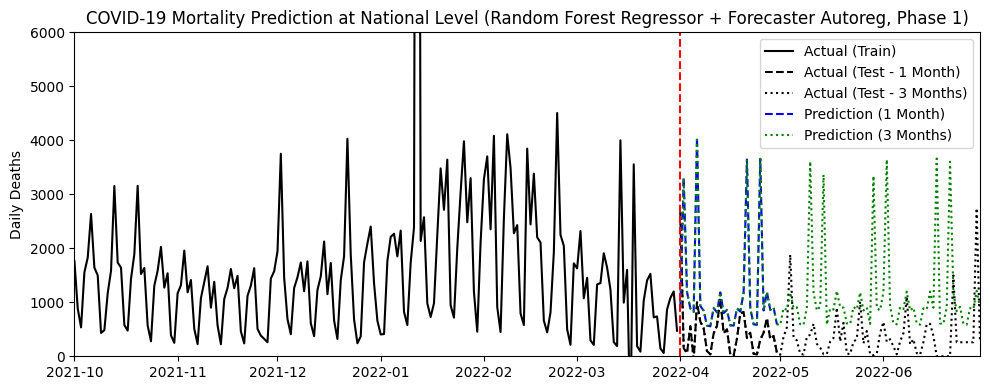

In [199]:
# Viz of predictions (national)

# Actual data
y_train_pivot = y_tr_phase1.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)
y_test_1month_pivot = y_te_phase1_1month.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)
y_test_3month_pivot = y_te_phase1_3month.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)

y_train_actual = y_train_pivot.groupby(y_train_pivot.index).sum()
y_test_actual_1month = y_test_1month_pivot.groupby(y_test_1month_pivot.index).sum()
y_test_actual_3month = y_test_3month_pivot.groupby(y_test_3month_pivot.index).sum()

# Predicted data
y_pred_1month = predictions_1month_phase1_national_autoreg
y_pred_3month = predictions_3month_phase1_national_autoreg

fig, ax = plt.subplots(figsize=(10, 4))

# Plot actual data
ax.plot(y_train_actual, color='black', label='Actual (Train)')
ax.plot(y_test_actual_1month, color='black', linestyle='--', label='Actual (Test - 1 Month)')
ax.plot(y_test_actual_3month, color='black', linestyle=':', label='Actual (Test - 3 Months)')

# Plot predictions
ax.plot(y_pred_1month, color='blue', linestyle='--', label='Prediction (1 Month)')
ax.plot(y_pred_3month, color='green', linestyle=':', label='Prediction (3 Months)')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 6, 30))) # Set the time range for x-axis (modify as per your data range)

ax.set_ylim(0, 6000)

ax.set_ylabel('Daily Deaths')
ax.set_title(f'COVID-19 Mortality Prediction at National Level (Random Forest Regressor + Forecaster Autoreg, Phase 1)')

plt.legend()
plt.tight_layout()
plt.show()

In [203]:
# Final model performance

mae_1month = mean_absolute_error(y_test_actual_1month, y_pred_1month)
mae_3month = mean_absolute_error(y_test_actual_3month, y_pred_3month)

r2_score_1month = r2_score(y_test_actual_1month, y_pred_1month)
r2_score_3month = r2_score(y_test_actual_3month, y_pred_3month)

mae_1month, mae_3month, r2_score_1month, r2_score_3month

(874.1757652746073, 849.3462724672489, -5.61529735475465, -5.670829860388861)

###### **Phase 2**

In [205]:
# Local configs
freq          = 'D' # pick: 'D' or 'W' (for some reason 'W' doesn't work as expected, so let's just keep daily)
n_estimators  = 2
max_depth     = 2
random_state  = 123
lags          = 21

In [206]:
# Model definition, training, and getting predictions

def train_and_predict_autoreg_model(X_train, y_train, X_test, lags):

    forecaster = ForecasterAutoreg(regressor=RandomForestRegressor(n_estimators = n_estimators,
                                                                   max_depth    = max_depth,
                                                                   random_state = random_state),
                                   lags=lags)
    forecaster.fit(y=y_train)
    predictions = forecaster.predict(steps=len(X_test))
    feature_importances = forecaster.get_feature_importances()
    return predictions, feature_importances

predictions_1month_phase2_state_autoreg           = {}
predictions_3month_phase2_state_autoreg           = {}
lagged_feature_importance_phase2_state_autoreg    = {}
model_performance_phase2_state_autoreg            = {}

for state in X_tr_phase2['recip_state'].unique():

    # Filter the X, y train data for the state
    X_train_state = X_tr_phase2[X_tr_phase2['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state'])
    y_train_state = y_tr_phase2[y_tr_phase2['recip_state'] == state].set_index('date').asfreq(freq)['daily_deaths'].fillna(method='ffill')

    # Filter the X test data for the state
    X_test_state_1month = X_te_phase2_1month[X_te_phase2_1month['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state']).fillna(method='ffill')
    X_test_state_3month = X_te_phase2_3month[X_te_phase2_3month['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state']).fillna(method='ffill')

    # Filter the y test data for the state
    y_true_1month = y_te_phase2_1month[y_te_phase2_1month['recip_state'] == state].set_index('date').asfreq(freq).fillna(method='ffill')['daily_deaths']
    y_true_3month = y_te_phase2_3month[y_te_phase2_3month['recip_state'] == state].set_index('date').asfreq(freq).fillna(method='ffill')['daily_deaths']

    if not X_train_state.empty and not y_train_state.empty:

        # Predict for 1-month and 3-month & get feature importances
        predictions_1month_phase2_state_autoreg[state], lagged_feature_importance_phase2_state_autoreg[state] = train_and_predict_autoreg_model(X_train_state, y_train_state, X_test_state_1month, lags)
        predictions_3month_phase2_state_autoreg[state], lagged_feature_importance_phase2_state_autoreg[state] = train_and_predict_autoreg_model(X_train_state, y_train_state, X_test_state_3month, lags)

        # Evaluate the perfomance for 1-month and 3-month
        r2_1month = r2_score(y_true_1month, predictions_1month_phase2_state_autoreg[state])
        mse_1month = mean_absolute_error(y_true_1month, predictions_1month_phase2_state_autoreg[state])

        r2_3month = r2_score(y_true_3month, predictions_3month_phase2_state_autoreg[state])
        mse_3month = mean_absolute_error(y_true_3month, predictions_3month_phase2_state_autoreg[state])

        model_performance_phase2_state_autoreg[state] = {'1month_R2': r2_1month, '1month_MSE': mse_1month, '3month_R2': r2_3month, '3month_MSE': mse_3month}

    else:
        print(f"No data available for state: {state}")

# Sum predictions to get national result
predictions_1month_phase2_national_autoreg = sum(predictions_1month_phase2_state_autoreg.values())
predictions_3month_phase2_national_autoreg = sum(predictions_3month_phase2_state_autoreg.values())

In [207]:
# Model performance evaluation per state

df_model_performance_phase2_state_autoreg = pd.DataFrame.from_dict(model_performance_phase2_state_autoreg, orient='index')
df_model_performance_phase2_state_autoreg.reset_index(inplace=True)
df_model_performance_phase2_state_autoreg.rename(columns={'index': 'State'}, inplace=True)
df_model_performance_phase2_state_autoreg.head(3)

,State,1month_R2,1month_MSE,3month_R2,3month_MSE
0,AK,-1.402756,6.079880,-2.795037,7.860302
1,AL,-0.021316,8.478555,-0.000003,11.420824
2,AR,-0.189524,5.579462,-0.124762,7.354202


In [208]:
# Model performance evaluation nationally

mean_1month_R2 = df_model_performance_phase1_state_autoreg['1month_R2'].mean()
mean_1month_MAE = df_model_performance_phase1_state_autoreg['1month_MAE'].mean()
mean_3month_R2 = df_model_performance_phase1_state_autoreg['3month_R2'].mean()
mean_3month_MAE = df_model_performance_phase1_state_autoreg['3month_MAE'].mean()

mean_1month_R2, mean_1month_MAE, mean_3month_R2, mean_3month_MAE

(-6.568748064878946,
 22.178598718343014,
 -3.439536474444915,
 20.629383794872236)

In [209]:
# Interpretability

combined_importances = pd.concat([pd.DataFrame(importances).assign(state=state) for state,
                                  importances in lagged_feature_importance_phase2_state_autoreg.items()])
fig = px.box(combined_importances, x='feature', y='importance',
             title='Total Lagged Feature Importances Across All States (Phase 2)')
fig.update_layout(xaxis_title='A lagged value of the daily death percentage', yaxis_title='Importance')
fig.show()

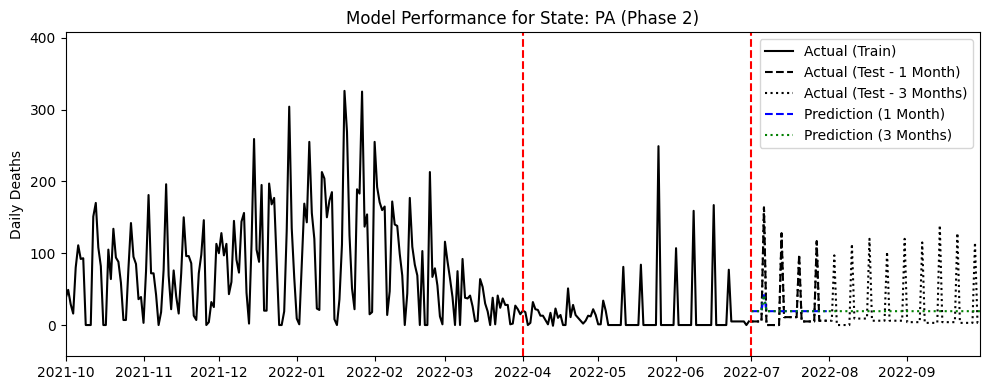

In [211]:
# Viz of predictions (state)

state = 'PA' # Pick the state

# Actual data
y_train_actual = y_tr_phase2[y_tr_phase2['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']
y_test_actual_1month = y_te_phase2_1month[y_te_phase2_1month['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']
y_test_actual_3month = y_te_phase2_3month[y_te_phase2_3month['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']

# Predicted data
y_pred_1month = pd.Series(predictions_1month_phase2_state_autoreg[state], index=y_test_actual_1month.index)
y_pred_3month = pd.Series(predictions_3month_phase2_state_autoreg[state], index=y_test_actual_3month.index)

fig, ax = plt.subplots(figsize=(10, 4))

# Plot actual data
ax.plot(y_train_actual, color='black', label='Actual (Train)')
ax.plot(y_test_actual_1month, color='black', linestyle='--', label='Actual (Test - 1 Month)')
ax.plot(y_test_actual_3month, color='black', linestyle=':', label='Actual (Test - 3 Months)')

# Plot predictions
ax.plot(y_pred_1month, color='blue', linestyle='--', label='Prediction (1 Month)')
ax.plot(y_pred_3month, color='green', linestyle=':', label='Prediction (3 Months)')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.axvline(x=datetime(2022, 7, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 9, 30))) # Set the time range for x-axis (modify as per your data range)


ax.set_ylabel('Daily Deaths')
ax.set_title(f'Model Performance for State: {state} (Phase 2)')

plt.legend()
plt.tight_layout()
plt.show()

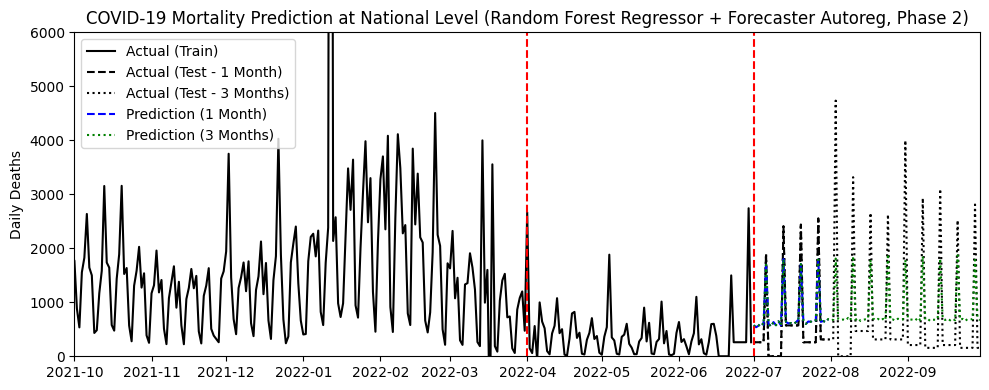

In [212]:
# Viz of predictions (national)

# Actual data
y_train_pivot = y_tr_phase2.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)
y_test_1month_pivot = y_te_phase2_1month.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)
y_test_3month_pivot = y_te_phase2_3month.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)

y_train_actual = y_train_pivot.groupby(y_train_pivot.index).sum()
y_test_actual_1month = y_test_1month_pivot.groupby(y_test_1month_pivot.index).sum()
y_test_actual_3month = y_test_3month_pivot.groupby(y_test_3month_pivot.index).sum()

# Predicted data
y_pred_1month = predictions_1month_phase2_national_autoreg
y_pred_3month = predictions_3month_phase2_national_autoreg

fig, ax = plt.subplots(figsize=(10, 4))

# Plot actual data
ax.plot(y_train_actual, color='black', label='Actual (Train)')
ax.plot(y_test_actual_1month, color='black', linestyle='--', label='Actual (Test - 1 Month)')
ax.plot(y_test_actual_3month, color='black', linestyle=':', label='Actual (Test - 3 Months)')

# Plot predictions
ax.plot(y_pred_1month, color='blue', linestyle='--', label='Prediction (1 Month)')
ax.plot(y_pred_3month, color='green', linestyle=':', label='Prediction (3 Months)')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.axvline(x=datetime(2022, 7, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 9, 30))) # Set the time range for x-axis (modify as per your data range)

ax.set_ylim(0, 6000)

ax.set_ylabel('Daily Deaths')
ax.set_title(f'COVID-19 Mortality Prediction at National Level (Random Forest Regressor + Forecaster Autoreg, Phase 2)')

plt.legend()
plt.tight_layout()
plt.show()

In [213]:
# Final model performance

mae_1month = mean_absolute_error(y_test_actual_1month, y_pred_1month)
mae_3month = mean_absolute_error(y_test_actual_3month, y_pred_3month)

r2_score_1month = r2_score(y_test_actual_1month, y_pred_1month)
r2_score_3month = r2_score(y_test_actual_3month, y_pred_3month)

mae_1month, mae_3month, r2_score_1month, r2_score_3month

(369.15669993259013, 513.9298807325143, 0.6493547744821808, 0.5673439447507193)

##### **Method 2: Random Forest Regressor + Feature Importance Techniques**
**Q2**: Can we accurately predict upcoming COVID-19 mortality rates to optimize healthcare resource planning?

**Q3**: What are the key factors driving COVID-19 mortality rates, enabling policymakers to target these areas effectively? What's the vaccine effectiveness

###### **Phase 1**

In [214]:
# Local configs
freq          = 'D' # pick: 'D' or 'W' (for some reason 'W' doesn't work as expected, so let's just keep daily)
n_estimators  = 2
max_depth     = 2
random_state  = 123

In [220]:
def train_model(X_train, y_train):

    model = RandomForestRegressor(n_estimators=2, max_depth=2, random_state=123)
    model.fit(X_train, y_train)
    return model

def predict(model, X_test):
    return model.predict(X_test)

predictions_1month_phase1_state_rf   = {}
predictions_3month_phase1_state_rf   = {}
feature_importance_phase1_state_rf   = {}
model_performance_phase1_state_rf    = {}

for state in X_tr_phase1['recip_state'].unique():

    # Filter data for the state
    X_train_state = X_tr_phase1[X_tr_phase1['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state', 'daily_death_pct'])
    y_train_state = y_tr_phase1[y_tr_phase1['recip_state'] == state].set_index('date').asfreq(freq)['daily_deaths']

    # Check if there is data for the state
    if not X_train_state.empty and not y_train_state.empty:

        # Train model
        model = train_model(X_train_state, y_train_state)

        # Predict for 1-month and 3-month
        X_test_state_1month = X_te_phase1_1month[X_te_phase1_1month['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state', 'daily_death_pct']).fillna(method='ffill')
        X_test_state_3month = X_te_phase1_3month[X_te_phase1_3month['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state', 'daily_death_pct']).fillna(method='ffill')

        predictions_1month_phase1_state_rf[state] = predict(model, X_test_state_1month)
        predictions_3month_phase1_state_rf[state] = predict(model, X_test_state_3month)

        # Evaluate the perfomance
        y_true_1month = y_te_phase1_1month[y_te_phase1_1month['recip_state'] == state].set_index('date').asfreq(freq).fillna(method='ffill')['daily_deaths']
        y_true_3month = y_te_phase1_3month[y_te_phase1_3month['recip_state'] == state].set_index('date').asfreq(freq).fillna(method='ffill')['daily_deaths']

        r2_1month = r2_score(y_true_1month, predictions_1month_phase1_state_rf[state])
        mse_1month = mean_squared_error(y_true_1month, predictions_1month_phase1_state_rf[state])

        r2_3month = r2_score(y_true_3month, predictions_3month_phase1_state_rf[state])
        mse_3month = mean_squared_error(y_true_3month, predictions_3month_phase1_state_rf[state])

        model_performance_phase1_state_rf[state] = {'1month_R2': r2_1month, '1month_MSE': mse_1month, '3month_R2': r2_3month, '3month_MSE': mse_3month}

        # Get feature importance (interpretability)
        results = permutation_importance(model, X_train_state, y_train_state, n_repeats=2)
        feature_importance_phase1_state_rf[state] = results.importances_mean

    else:
        print(f"No data available for state: {state}")

# Sum predictions to get national result
predictions_1month_phase1_national_rf = sum(predictions_1month_phase1_state_rf.values())
predictions_3month_phase1_national_rf = sum(predictions_3month_phase1_state_rf.values())


In [221]:
# Model performance evaluation per state

df_model_performance_phase1_state_rf = pd.DataFrame.from_dict(model_performance_phase1_state_rf, orient='index')
df_model_performance_phase1_state_rf.reset_index(inplace=True)
df_model_performance_phase1_state_rf.rename(columns={'index': 'State'}, inplace=True)
df_model_performance_phase1_state_rf.head(3)

,State,1month_R2,1month_MSE,3month_R2,3month_MSE
0,AK,0.349464,4.409910,0.148904,7.753290
1,AL,-7.855982,1098.545223,-18.651172,1299.592446
2,AR,-15.070687,250.863424,-13.312402,289.417815


In [223]:
# Interpretability

feature_names = X_te_phase1_1month.drop(columns=['recip_state', 'date']).columns.tolist()

feature_importance_data = {'State': [],
                           'Feature': [],
                           'Importance': []}

for state, importances in feature_importance_phase1_state_rf.items():
    for i, importance in enumerate(importances):
        feature_importance_data['State'].append(state)
        feature_importance_data['Feature'].append(feature_names[i])
        feature_importance_data['Importance'].append(importance)

df_feature_importances = pd.DataFrame(feature_importance_data)
df_feature_importances.sample(3)

fig = px.box(df_feature_importances, x='Feature', y='Importance',
             title="Total Feature Importances Across All States (Phase 1)",
             labels={'Feature': 'Features', 'Importance': 'Importance'})

fig.update_layout(
    xaxis_tickangle=-90,
    xaxis_title='Feature',
    yaxis_title='Importance',
    xaxis={'categoryorder':'total descending'})

fig.show()

How to read the chart:
* Each box corresponds to a feature used in the model. The label on the x-axis indicates the name of the feature.
* The vertical axis (y-axis) represents the importance score assigned to each feature. Higher scores imply that the feature has a greater impact on the model's predictions.

**Takeaway: As we can see, vaccination features are the most important ones and account for significant variation in the daily death percentage.**


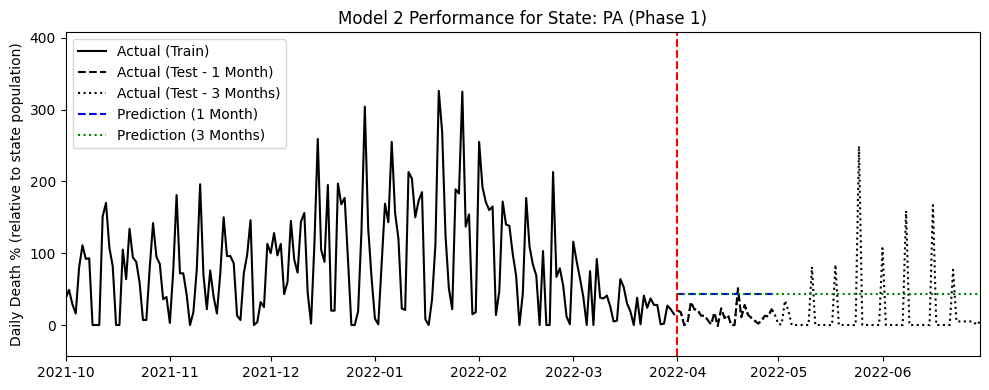

In [224]:
# Viz of predictions (state)

state = 'PA' # Pick the state

# Actual data
y_train_actual = y_tr_phase1[y_tr_phase1['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']
y_test_actual_1month = y_te_phase1_1month[y_te_phase1_1month['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']
y_test_actual_3month = y_te_phase1_3month[y_te_phase1_3month['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']

# Predicted data
y_pred_1month = pd.Series(predictions_1month_phase1_state_rf[state], index=y_test_actual_1month.index)
y_pred_3month = pd.Series(predictions_3month_phase1_state_rf[state], index=y_test_actual_3month.index)

fig, ax = plt.subplots(figsize=(10, 4))

# Plot actual data
ax.plot(y_train_actual, color='black', label='Actual (Train)')
ax.plot(y_test_actual_1month, color='black', linestyle='--', label='Actual (Test - 1 Month)')
ax.plot(y_test_actual_3month, color='black', linestyle=':', label='Actual (Test - 3 Months)')

# Plot predictions
ax.plot(y_pred_1month, color='blue', linestyle='--', label='Prediction (1 Month)')
ax.plot(y_pred_3month, color='green', linestyle=':', label='Prediction (3 Months)')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 6, 30))) # Set the time range for x-axis (modify as per your data range)

ax.set_ylabel('Daily Death % (relative to state population)')
ax.set_title(f'Model 2 Performance for State: {state} (Phase 1)')

plt.legend()
plt.tight_layout()
plt.show()

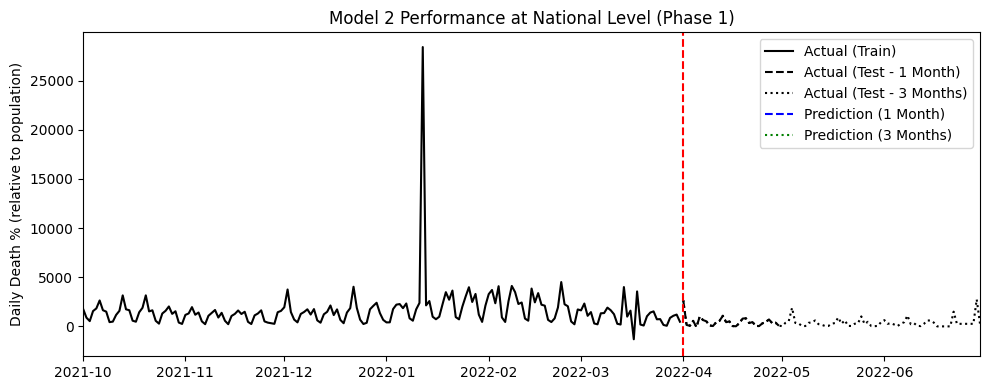

In [225]:
# Viz of predictions (national)

# Actual data
y_train_pivot = y_tr_phase1.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)
y_test_1month_pivot = y_te_phase1_1month.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)
y_test_3month_pivot = y_te_phase1_3month.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)

y_train_actual = y_train_pivot.groupby(y_train_pivot.index).sum()
y_test_actual_1month = y_test_1month_pivot.groupby(y_test_1month_pivot.index).sum()
y_test_actual_3month = y_test_3month_pivot.groupby(y_test_3month_pivot.index).sum()

# Predicted data
y_pred_1month = predictions_1month_phase1_national_rf
y_pred_3month = predictions_3month_phase1_national_rf

fig, ax = plt.subplots(figsize=(10, 4))

# Plot actual data
ax.plot(y_train_actual, color='black', label='Actual (Train)')
ax.plot(y_test_actual_1month, color='black', linestyle='--', label='Actual (Test - 1 Month)')
ax.plot(y_test_actual_3month, color='black', linestyle=':', label='Actual (Test - 3 Months)')

# Plot predictions
ax.plot(y_pred_1month, color='blue', linestyle='--', label='Prediction (1 Month)')
ax.plot(y_pred_3month, color='green', linestyle=':', label='Prediction (3 Months)')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 6, 30))) # Set the time range for x-axis (modify as per your data range)

ax.set_ylabel('Daily Death % (relative to population)')
ax.set_title(f'Model 2 Performance at National Level (Phase 1)')

plt.legend()
plt.tight_layout()
plt.show()

In [226]:
# Final model performance

mae_1month = mean_absolute_error(y_test_actual_1month, y_pred_1month)
mae_3month = mean_absolute_error(y_test_actual_3month, y_pred_3month)

r2_score_1month = r2_score(y_test_actual_1month, y_pred_1month)
r2_score_3month = r2_score(y_test_actual_3month, y_pred_3month)

mae_1month, mae_3month, r2_score_1month, r2_score_3month

(1110.553404870983, 1065.982072863683, -3.9331360883093325, -4.152735111096308)

###### **Phase 2**

In [227]:
# Local configs
freq          = 'D' # pick: 'D' or 'W' (for some reason 'W' doesn't work as expected, so let's just keep daily)
n_estimators  = 2
max_depth     = 2
random_state  = 123

In [229]:
def train_model(X_train, y_train):

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=123)
    model.fit(X_train, y_train)
    return model

def predict(model, X_test):
    return model.predict(X_test)

predictions_1month_phase2_state_rf   = {}
predictions_3month_phase2_state_rf   = {}
feature_importance_phase2_state_rf   = {}
model_performance_phase2_state_rf    = {}

for state in X_tr_phase2['recip_state'].unique():

    # Filter data for the state
    X_train_state = X_tr_phase2[X_tr_phase2['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state', 'daily_death_pct'])
    y_train_state = y_tr_phase2[y_tr_phase2['recip_state'] == state].set_index('date').asfreq(freq)['daily_deaths']

    # Check if there is data for the state
    if not X_train_state.empty and not y_train_state.empty:

        # Train model
        model = train_model(X_train_state, y_train_state)

        # Predict for 1-month and 3-month
        X_test_state_1month = X_te_phase2_1month[X_te_phase2_1month['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state', 'daily_death_pct']).fillna(method='ffill')
        X_test_state_3month = X_te_phase2_3month[X_te_phase2_3month['recip_state'] == state].set_index('date').asfreq(freq).drop(columns=['recip_state', 'daily_death_pct']).fillna(method='ffill')

        predictions_1month_phase2_state_rf[state] = predict(model, X_test_state_1month)
        predictions_3month_phase2_state_rf[state] = predict(model, X_test_state_3month)

        # Evaluate the perfomance
        y_true_1month = y_te_phase2_1month[y_te_phase2_1month['recip_state'] == state].set_index('date').asfreq(freq).fillna(method='ffill')['daily_deaths']
        y_true_3month = y_te_phase2_3month[y_te_phase2_3month['recip_state'] == state].set_index('date').asfreq(freq).fillna(method='ffill')['daily_deaths']

        r2_1month = r2_score(y_true_1month, predictions_1month_phase2_state_rf[state])
        mse_1month = mean_squared_error(y_true_1month, predictions_1month_phase2_state_rf[state])

        r2_3month = r2_score(y_true_3month, predictions_3month_phase2_state_rf[state])
        mse_3month = mean_squared_error(y_true_3month, predictions_3month_phase2_state_rf[state])

        model_performance_phase2_state_rf[state] = {'1month_R2': r2_1month, '1month_MSE': mse_1month, '3month_R2': r2_3month, '3month_MSE': mse_3month}

        # Get feature importance (interpretability)
        results = permutation_importance(model, X_train_state, y_train_state, n_repeats=2)
        feature_importance_phase2_state_rf[state] = results.importances_mean

    else:
        print(f"No data available for state: {state}")

# Sum predictions to get national result
predictions_1month_phase2_national_rf = sum(predictions_1month_phase2_state_rf.values())
predictions_3month_phase2_national_rf = sum(predictions_3month_phase2_state_rf.values())


In [230]:
# Model performance evaluation per state

df_model_performance_phase2_state_rf = pd.DataFrame.from_dict(model_performance_phase2_state_rf, orient='index')
df_model_performance_phase2_state_rf.reset_index(inplace=True)
df_model_performance_phase2_state_rf.rename(columns={'index': 'State'}, inplace=True)
df_model_performance_phase2_state_rf.head(3)

,State,1month_R2,1month_MSE,3month_R2,3month_MSE
0,AK,-0.691822,43.642316,-0.608701,34.239440
1,AL,-0.538234,207.102944,-1.734658,1119.819032
2,AR,-0.376053,101.066119,-0.107292,270.441957


In [231]:
# Interpretability

feature_names = X_te_phase2_1month.drop(columns=['recip_state', 'date', 'daily_death_pct']).columns.tolist()

feature_importance_data = {'State': [],
                           'Feature': [],
                           'Importance': []}

for state, importances in feature_importance_phase2_state_rf.items():
    for i, importance in enumerate(importances):
        feature_importance_data['State'].append(state)
        feature_importance_data['Feature'].append(feature_names[i])
        feature_importance_data['Importance'].append(importance)

df_feature_importances = pd.DataFrame(feature_importance_data)
df_feature_importances.sample(3)

fig = px.box(df_feature_importances, x='Feature', y='Importance',
             title="Total Feature Importances Across All States (Phase 2)",
             labels={'Feature': 'Features', 'Importance': 'Importance'})

fig.update_layout(
    xaxis_tickangle=-90,
    xaxis_title='Feature',
    yaxis_title='Importance',
    xaxis={'categoryorder':'total descending'})

fig.show()

In [243]:
# Calculating average importance for each feature
average_importances = df_feature_importances.groupby('Feature')['Importance'].mean()

# Sorting and selecting top 10 features
top_10_features = average_importances.sort_values(ascending=False).head(10).index

# Filtering data for top 10 features
df_top_10_features = df_feature_importances[df_feature_importances['Feature'].isin(top_10_features)]

# Plotting the boxplot
fig = px.box(df_top_10_features, x='Importance', y='Feature',
             title="Top 10 Feature Importances Across All States",
             labels={'Feature': 'Features', 'Importance': 'Importance'})

# Rotating x-axis labels
fig.update_layout(xaxis_tickangle=-90)
fig.show()


In [251]:
average_importance_per_feature = df_top_10_features.groupby('Feature')['Importance'].mean()
average_importance_per_feature

Feature
dayofweek_1               0.031848
dayofweek_2               0.084163
dayofweek_5               0.016289
dayofweek_6               0.017360
month_2                   0.025694
month_9                   0.017126
pct_doses_admin_12plus    0.429657
pct_doses_admin_18plus    0.132083
pct_doses_admin_5plus     0.098854
pct_doses_admin_65plus    0.474424
Name: Importance, dtype: float64

In [259]:
# Sample data
average_importance_per_feature = {
    'Feature': ['Day of Week 1', 'Day of Week 2', 'Day of Week 5', 'Day of Week 6', 'Month 2',
                'Month 9', 'Dose Administration Percentage (Age 12+)', 'Dose Administration Percentage (Age 18+)',
                'Dose Administration Percentage (Age 5+)', 'Dose Administration Percentage (Age 65+)'],
    'Importance': [0.031848, 0.084163, 0.016289, 0.017360, 0.025694,
                   0.017126, 0.429657, 0.132083, 0.098854, 0.474424]}

df_average_importance = pd.DataFrame(average_importance_per_feature)

# Sorting by importance in descending order
df_average_importance_sorted = df_average_importance.sort_values(by='Importance', ascending=True)

# Plotting
fig = px.bar(df_average_importance_sorted, x='Importance', y='Feature', orientation='h',
             title="Average Feature Importance of COVID-19 Mortality Prediction",
             labels={'Feature': 'Feature', 'Importance': 'Average Importance'})
fig.show()


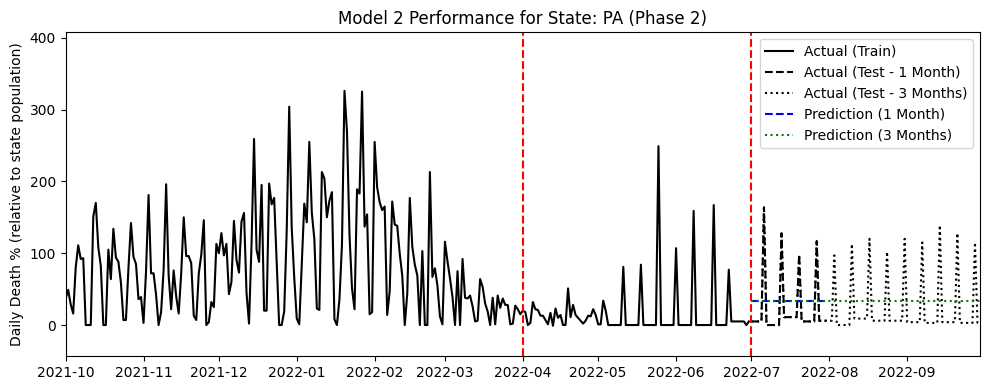

In [232]:
# Viz of predictions (state)

state = 'PA' # Pick the state

# Actual data
y_train_actual = y_tr_phase2[y_tr_phase2['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']
y_test_actual_1month = y_te_phase2_1month[y_te_phase2_1month['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']
y_test_actual_3month = y_te_phase2_3month[y_te_phase2_3month['recip_state'] == state].set_index('date').asfreq('D')['daily_deaths']

# Predicted data
y_pred_1month = pd.Series(predictions_1month_phase2_state_rf[state], index=y_test_actual_1month.index)
y_pred_3month = pd.Series(predictions_3month_phase2_state_rf[state], index=y_test_actual_3month.index)

fig, ax = plt.subplots(figsize=(10, 4))

# Plot actual data
ax.plot(y_train_actual, color='black', label='Actual (Train)')
ax.plot(y_test_actual_1month, color='black', linestyle='--', label='Actual (Test - 1 Month)')
ax.plot(y_test_actual_3month, color='black', linestyle=':', label='Actual (Test - 3 Months)')

# Plot predictions
ax.plot(y_pred_1month, color='blue', linestyle='--', label='Prediction (1 Month)')
ax.plot(y_pred_3month, color='green', linestyle=':', label='Prediction (3 Months)')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.axvline(x=datetime(2022, 7, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 9, 30))) # Set the time range for x-axis (modify as per your data range)

ax.set_ylabel('Daily Death % (relative to state population)')
ax.set_title(f'Model 2 Performance for State: {state} (Phase 2)')

plt.legend()
plt.tight_layout()
plt.show()

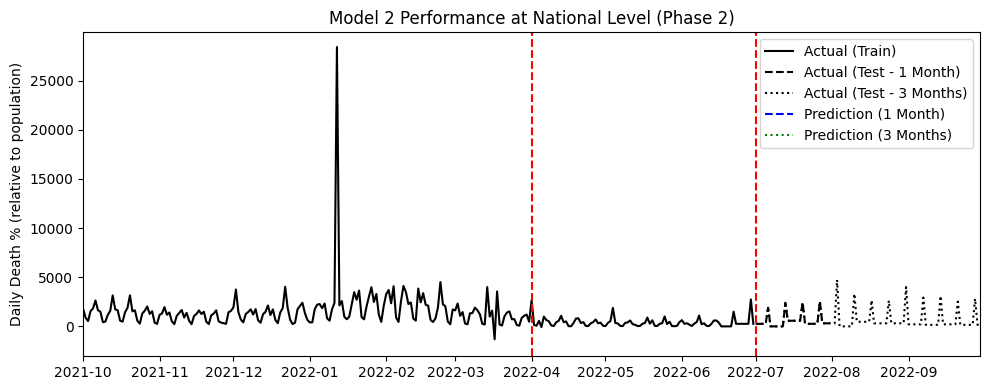

In [234]:
# Viz of predictions (national)

# Actual data
y_train_pivot = y_tr_phase2.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)
y_test_1month_pivot = y_te_phase2_1month.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)
y_test_3month_pivot = y_te_phase2_3month.pivot(index='date', columns='recip_state', values='daily_deaths').sum(axis=1)

y_train_actual = y_train_pivot.groupby(y_train_pivot.index).sum()
y_test_actual_1month = y_test_1month_pivot.groupby(y_test_1month_pivot.index).sum()
y_test_actual_3month = y_test_3month_pivot.groupby(y_test_3month_pivot.index).sum()

# Predicted data
y_pred_1month = predictions_1month_phase2_national_rf
y_pred_3month = predictions_3month_phase2_national_rf

fig, ax = plt.subplots(figsize=(10, 4))

# Plot actual data
ax.plot(y_train_actual, color='black', label='Actual (Train)')
ax.plot(y_test_actual_1month, color='black', linestyle='--', label='Actual (Test - 1 Month)')
ax.plot(y_test_actual_3month, color='black', linestyle=':', label='Actual (Test - 3 Months)')

# Plot predictions
ax.plot(y_pred_1month, color='blue', linestyle='--', label='Prediction (1 Month)')
ax.plot(y_pred_3month, color='green', linestyle=':', label='Prediction (3 Months)')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.axvline(x=datetime(2022, 7, 1), color='red', linestyle='--') # Mark the beginning of the test period
ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 9, 30))) # Set the time range for x-axis (modify as per your data range)

ax.set_ylabel('Daily Death % (relative to population)')
ax.set_title(f'Model 2 Performance at National Level (Phase 2)')

plt.legend()
plt.tight_layout()
plt.show()

In [235]:
# Final model performance

mae_1month = mean_absolute_error(y_test_actual_1month, y_pred_1month)
mae_3month = mean_absolute_error(y_test_actual_3month, y_pred_3month)

r2_score_1month = r2_score(y_test_actual_1month, y_pred_1month)
r2_score_3month = r2_score(y_test_actual_3month, y_pred_3month)

mae_1month, mae_3month, r2_score_1month, r2_score_3month

(676.6461777704043,
 946.2475808431467,
 -0.1926763575536159,
 -0.18209995242886245)

##### **Method 3: Comparative analysis of models predictive power for 1- vs 3-month forecast.**
**Q4**: How can we detect model drift over time to determine if the same predictive model remains valid for extended periods?

In [ ]:
# Add a column to identify the model
df_model_performance_phase1_state_autoreg['Model'] = 'Autoreg'
df_model_performance_phase1_state_rf['Model'] = 'RF'

# Combine the two DataFrames
combined_df = pd.concat([df_model_performance_phase1_state_autoreg, df_model_performance_phase1_state_rf])
ordered_columns = ['State', 'Model', '1month_R2', '3month_R2', '1month_MSE', '3month_MSE']
combined_df = combined_df[ordered_columns]

metrics = ['1month_R2', '1month_MSE', '3month_R2', '3month_MSE']

# Filter out outliers
percentiles = {metric: {'lower': combined_df[metric].quantile(0.02),
                        'upper': combined_df[metric].quantile(0.98)} for metric in metrics}

for metric in metrics:
    lower_bound = percentiles[metric]['lower']
    upper_bound = percentiles[metric]['upper']
    combined_df = combined_df[(combined_df[metric] >= lower_bound) &
                              (combined_df[metric] <= upper_bound)]

# Melt the DataFrame to have 'long' format
melted_df = combined_df.melt(id_vars=['State', 'Model'], value_vars=['1month_R2', '3month_R2', '1month_MSE', '3month_MSE'],
                             var_name='Metric', value_name='Value')

# Create the grouped boxplot
fig = px.box(melted_df, x='Metric', y='Value', color='Model',
             title='Comparative Analysis of Model Predictive Power for 1- vs 3-month Forecast (Phase 1)')

fig.update_layout(xaxis_title='Metric', yaxis_title='Value')
fig.show()

In [ ]:
combined_df.describe()

,1month_R2,3month_R2,1month_MSE,3month_MSE
count,86.000000,86.000000,8.600000e+01,8.600000e+01
mean,-3.969208,-0.788612,7.135756e-11,4.660074e-11
std,7.229940,1.439179,2.036370e-10,8.750027e-11
min,-37.376853,-6.366089,7.383467e-13,5.335471e-12
25%,-4.968644,-0.912323,2.914020e-12,7.445363e-12
50%,-0.652614,-0.158613,1.168856e-11,1.655896e-11
75%,-0.010158,-0.008675,3.407014e-11,3.342362e-11
max,0.688850,0.161600,1.195657e-09,5.277749e-10


##### **Method 4: tbc**
**Q5 (Optional)**: Is there a noticeable lag between vaccine administration and its effectiveness, to assist policymakers in timing new vaccination campaigns?

In [ ]:
# TODO

#### **Useful references**

- https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1
- https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
- https://skforecast.org/0.11.0/